In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from lmfit import Parameters, minimize
from numba import jit, njit, prange, float64,complex64
from payoff_function import PayoffFunctions as payoff

In [2]:
# complex number used in function
i = complex(0, 1)
DATA_FOLDER = "../Data"

##### 1. Defining f which would be used in Heston Pricer

In [3]:
# To be used in the Heston pricer
@jit
def fHeston(s, St, K, r, T, sigma, kappa, theta, volvol, rho):
    # To be used a lot
    prod = rho * sigma *i *s 
    
    # Calculate d
    d1 = (prod - kappa)**2
    d2 = (sigma**2) * (i*s + s**2)
    d = np.sqrt(d1 + d2)
    
    # Calculate g
    g1 = kappa - prod - d
    g2 = kappa - prod + d
    g = g1/g2
    
    # Calculate first exponential
    exp1 = np.exp(np.log(St) * i *s) * np.exp(i * s* r* T)
    exp2 = 1 - g * np.exp(-d *T)
    exp3 = 1- g
    mainExp1 = exp1 * np.power(exp2/ exp3, -2 * theta * kappa/(sigma **2))
    
    # Calculate second exponential
    exp4 = theta * kappa * T/(sigma **2)
    exp5 = volvol/(sigma **2)
    exp6 = (1 - np.exp(-d * T))/(1 - g * np.exp(-d * T))
    mainExp2 = np.exp((exp4 * g1) + (exp5 *g1 * exp6))
    
    return (mainExp1 * mainExp2)


C:\Windows\Temp\ipykernel_41672\3593397540.py:3: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def fHeston(s, St, K, r, T, sigma, kappa, theta, volvol, rho):


##### 2. Computing the integral and Full Pricer
- Selecting a limit = 100 
- Selecting an integration scheme = Riemann sum

In [4]:
# Heston Pricer (allow for parallel processing with numba)
@jit(forceobj=True)
def priceHestonMid(St, K, r, T, sigma, kappa, theta, volvol, rho):
    P, iterations, maxNumber = 0,1000,100
    ds = maxNumber/iterations
    
    element1 = 0.5 * (St - K * np.exp(-r * T))
    
    # Calculate the complex integral
    # Using j instead of i to avoid confusion
    for j in prange(1, iterations):
        s1 = ds * (2*j + 1)/2
        s2 = s1 - i
        
        numerator1 = fHeston(s2,  St, K, r, T, sigma, kappa, theta, volvol, rho)
        numerator2 = K * fHeston(s1,  St, K, r, T, sigma, kappa, theta, volvol, rho)
        denominator = np.exp(np.log(K) * i * s1) *i *s1
        
        P = P + ds *(numerator1 - numerator2)/denominator
    
    element2 = P/np.pi
    
    return np.real((element1 + element2))

In [5]:
maturities = []
strikes = []
marketPrices = []
for j in range(11):
    prices_ = []
    strikes_ = []
    maturities_ = []

    temp = pd.read_excel(f'{DATA_FOLDER}/{j+1}.xlsx')

    maturity = temp['Strike'][0]
    temp = temp.iloc[1:,:]
    strike = list(temp['Strike'].values)
    price = list(temp['Mid'].values)

    for k in range(len(strike)):
        if price[k] != 0 and not np.isnan(price[k]):
            prices_.append(price[k])
            strikes_.append(strike[k])
            maturities_.append(maturity+1/252)
    
    maturities=maturities+maturities_
    strikes=strikes+strikes_
    marketPrices=marketPrices+prices_
maturities=np.array(maturities)
strikes=np.array(strikes)
marketPrices=np.array(marketPrices)
    

In [6]:
print(len(maturities))
print(len(strikes))
print(len(marketPrices))

1369
1369
1369


In [7]:
# interest rate on 9 Aug 2023
rate = 3.325601/100

In [10]:
# This is the calibration function
def calibratorHeston(St, initialValues = [0.17,0.5,0.5,0.5,-0.5], 
                              lowerBounds = [1e-2,1e-2,1e-2,1e-2,-1], 
                              upperBounds = [1,3,1,5,0]):
    '''Implementation of the Levenberg Marquardt algorithm in Python to find the optimal value 
        based on a given volatility surface.
    '''
        
    '''1) Define parameters
    =========================='''
    params = Parameters()
    params.add('sigma',value = initialValues[0], min = lowerBounds[0], max = upperBounds[0])
    params.add('kappa',value = initialValues[1], min = lowerBounds[1], max = upperBounds[1])
    params.add('theta',value = initialValues[2], min = lowerBounds[2], max = upperBounds[2])
    params.add('volvol', value = initialValues[3], min = lowerBounds[3], max = upperBounds[3])
    params.add('rho', value = initialValues[4], min = lowerBounds[4], max = upperBounds[4])
    
    '''2) Define objective function
    ================================'''
    objectiveFunctionHeston = lambda paramVect: (marketPrices - priceHestonMid(St, strikes,  
                                                                        rate, 
                                                                        maturities, 
                                                                        paramVect['sigma'].value,                         
                                                                        paramVect['kappa'].value,
                                                                        paramVect['theta'].value,
                                                                        paramVect['volvol'].value,
                                                                        paramVect['rho'].value))/marketPrices   
    
    '''3) Optimize parameters
    =============================='''
    result = minimize(objectiveFunctionHeston, 
                      params, 
                      method = 'leastsq',
                      ftol = 1e-6)
    return(result)

In [11]:
# underlying price on 9 Aug 2023
result = calibratorHeston(4317.33)

In [12]:
result

In [13]:
Nsim = 1000000
S = 4317.33
T = 485/252
r = 3.325601/100
steps = 485


# Heston Parameters
v_0 = 0.99999979
kappa = 2.99995740
theta = 0.01003860
xi = 0.01000034
rho = -0.64633133

In [14]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
    
    if return_vol:
        return prices, sigs
    
    return prices

In [15]:
sim_prices = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, steps, Nsim, return_vol=False)

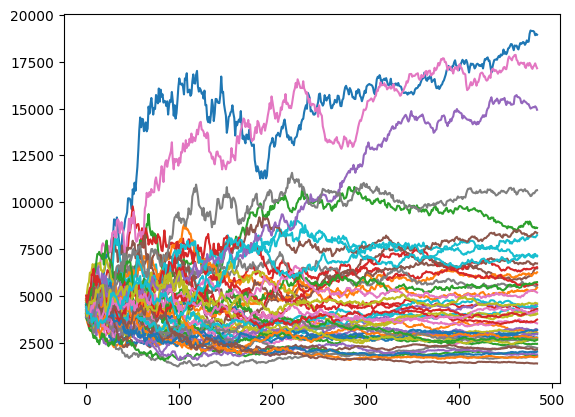

In [16]:
for i in range(50, 100):
    plt.plot(sim_prices[i,:])
plt.show()

In [17]:
sim_prices = pd.DataFrame(sim_prices)
sim_Note = np.exp(-r*T)*sim_prices.apply(payoff.payoff_original, axis=1)
note_MC = np.mean(sim_Note)
note_MC_var = np.var(sim_Note)/Nsim
lower_percentile = note_MC-1.96*np.sqrt(note_MC_var)
higher_percentile = note_MC+1.96*np.sqrt(note_MC_var)

In [25]:
print(f"Note Value (MC): {note_MC:.2f}")
print(f"Estimate Variance: {note_MC_var}")
print(f"95% Confidence Interval: [{lower_percentile:.2f}, {higher_percentile:.2f}]")

Note Value (MC): 1504.36
Estimate Variance: 1.2386614411180985
95% Confidence Interval: [1502.18, 1506.54]


In [22]:
print(f"Mean Absolute Error: {abs(1291.46-note_MC):.2f}")

Mean Absolute Error: 212.90
